In [52]:
from Crypto.Random import random
from fastecdsa.curve import P256
from fastecdsa.point import Point
from fastecdsa.util import mod_sqrt
from tqdm.notebook import tqdm

# Prerequisites

- PRNG
- Elliptic curves
- ECDLP

# Theory

PRNG refresher

$
\boxed{s_0} \\
\big \downarrow \ f\\
\boxed{s_1} \overset{g}{\longrightarrow} r_1 \\
\big\downarrow \ f\\
\boxed{s_2} \overset{g}{\longrightarrow} r_2 \\
\big\downarrow \ f\\
\boxed{s_3} \overset{g}{\longrightarrow} r_3 \\
$

where $f$ and $g$ are functions (problems) that are unfeasable to reverse

Let 
- $E$ be an elliptic curve
- $P, Q \in E$ 
- $Q = kP$ with $k \in \mathbb{Z}$
- $s_i$ will be our internal state at step $i$
- $r_i$ will be our output at step $i$

ECDLP
> If you know $P$ and $Q$ it's unfeasable to find $k$

- We will use ECDLP as our one way function to maintain our forward and backward secrecy

DRBG = Dual Elliptic Curve Deterministic Random Bit Generator
- Use the number curve P256 with some handpicked $P, Q$
- https://www.youtube.com/watch?v=OkiVN6z60lg&t - MUST WATCH 
- https://rump2007.cr.yp.to/15-shumow.pdf


**Forward secrecy**
> If an internal state is compromised(known), the previous states cannot be compromised


**Backward secrecy**
> If an internal state is compromised(known), the future states cannot be compromised


- https://www.youtube.com/watch?v=IkM3R-KDu44

## Version 1

- https://www.youtube.com/watch?v=ulg_AHBOIQU

$
\boxed{s_0} \\
\Bigg \downarrow  (s_0\cdot P).x\\
\boxed{s_1} \overset{(s_1\cdot Q).x}{\longrightarrow} r_1 \longrightarrow r_1[:240]\\
\Bigg\downarrow (s_1\cdot P).x\\
\boxed{s_2} \overset{(s_2\cdot Q).x}{\longrightarrow} r_2 \longrightarrow r_2[:240]\\
\Bigg\downarrow (s_2\cdot P).x\\
\boxed{s_3} \overset{(s_3\cdot Q).x}{\longrightarrow} r_3 \longrightarrow r_3[:240]\\
$


## Security
The strength of this PRNG is based on the ECDLP
- $R = (r_x, r_y), Q, P$
- $R = s_i \cdot Q$
- knowing $R$ you cannot compute $s_i$
- $P = e \cdot Q$
	- If $P$ and $Q$ are truly random then $e$ is random then the PRNG is fine

	
## The backdoor
But if $e$ is not random ($e$ is the backdoor) then 
- $s_i\cdot P = s_i \cdot (e \cdot Q) = e \cdot s_i \cdot Q = e \cdot R$ 
- So $s_{i+1} = (e \cdot R).x$ => We get the next state

### The attack plan
If we can choose $P$ and $Q$ let's us choose $Q$ such that $Q = P$
- If $P = Q =>$ 
	- $r_1 = (s_1 \cdot P).x = s_2$ 
	- $r_2 = (s_2 \cdot P).x = s_3$ 
- Find 
    - Find $r_1[:240]$
    - Find $r_2[:240]$
    - Find $s_2$ by brute forcing the first $2^{16}b$ of $r_1 (= s_2)$ and testing if $\underbrace{(r_1 \cdot P).x}_{s_3}[:240] == r_2[:240]$
    - If I find $s_2$ I broke the PRNG

## Version 2

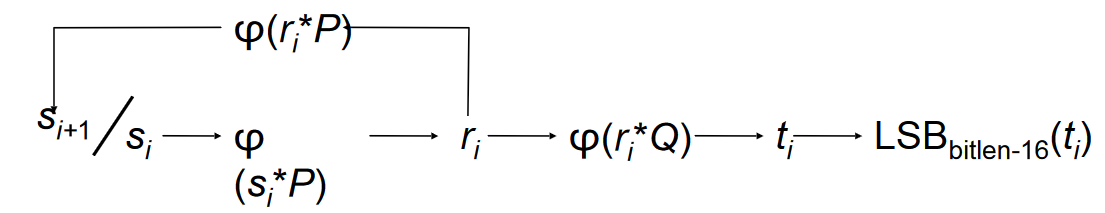
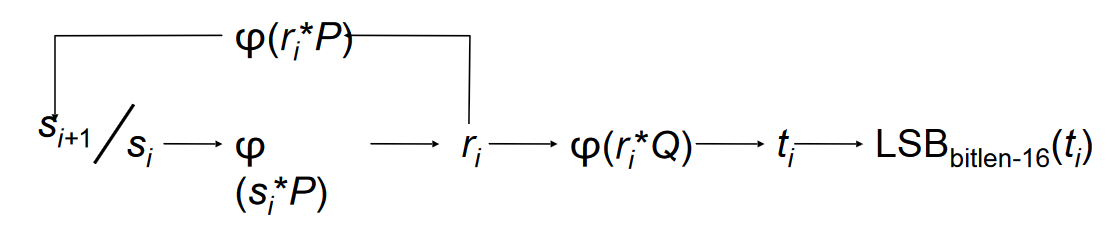

- https://www.youtube.com/watch?v=nybVFJVXbww&t

$
\boxed{s_0} \\
\Bigg \downarrow  (s_0\cdot P).x\\
r_0 \overset{(r_0\cdot Q).x}{\longrightarrow} t_0  \longrightarrow t_0[:240]\\\\
\Bigg \downarrow  (r_0\cdot P).x \\
\boxed{s_1} \\
\Bigg \downarrow  (s_1\cdot P).x\\
r_1 \overset{(r_1\cdot Q).x}{\longrightarrow} t_1 \longrightarrow t_1[:240]\\\\
\Bigg \downarrow  (r_1\cdot P).x \\
\boxed{s_2}  \\
\Bigg \downarrow  (s_2\cdot P).x\\
r_2 \overset{(r_2\cdot Q).x}{\longrightarrow} t_2  \longrightarrow t_2[:240]\\\\
\Bigg \downarrow  (r_2\cdot P).x \\
\boxed{s_3}
$

- Backdoor is similar

# Code

## Version 1

In [75]:
class Dual_EC_DRBG1:
    def __init__(self, seed, P, Q):
        self.seed = seed
        self.P = P
        self.Q = Q

    def next_num(self):
        s0 = self.seed
        s1 = (s0 * self.P).x
        r1 = (s1 * self.Q).x

        self.seed = s1
        return r1 & (2 ** (240) - 1)

In [76]:
P = P256.G
Q = random.getrandbits(256) * P
seed = random.getrandbits(60)
rng = Dual_EC_DRBG1(seed, P, Q)

In [77]:
print([rng.next_num() for i in range(3)])

[1231552060546413391318023453567188090058266792110274047592427562515379405, 1216758479565553634918843678377486776810471339166733586950286515033720989, 737040477072736357580008044487283109729120428264536331387468969326099282]


### Breaking it

In [78]:
P = P256.G
seed = random.getrandbits(60)
rng = Dual_EC_DRBG1(seed, P, P)
rng.next_num()

654943182701178462091613576910994236387368131806757211391255622607623880

In [79]:
n1 = rng.next_num()  # r1[:240]
n2 = rng.next_num()  # r2[:240]
n1, n2

(1120705333011838021085717443044728103621641585710624670403295934388955926,
 874745977888782828975052128375260260196665258740514531363400575549275986)

In [80]:
nr_r = 0
for i in tqdm(range(2**16)):
    r1 = (i << 240) + n1
    r1y = P256.evaluate(r1)  # get y^2
    r1y = mod_sqrt(r1y, P256.p)[0]  # get y
    if P256.is_point_on_curve((r1, r1y)):  # test if the point is on curve
        nr_r += 1
        n2_pred = (r1 * P).x & (2 ** (240) - 1)
    if n2 == n2_pred:  # r2 = n2
        print(r1, n2_pred)
        break

102356338015009594435111093232981057268505591271487192487613172143017145199382 874745977888782828975052128375260260196665258740514531363400575549275986



In [82]:
rng_break = Dual_EC_DRBG1(r1, P, P)  # s2

In [83]:
print([rng_break.next_num() == rng.next_num() for _ in range(10)])

[True, True, True, True, True, True, True, True, True, True]


## Version 2

In [29]:
class Dual_EC_DRBG2:
    def __init__(self, seed, P, Q):
        self.seed = seed
        self.P = P
        self.Q = Q

    def next_num(self):
        s0 = self.seed
        r0 = (s0 * self.P).x
        t0 = (r0 * self.Q).x

        s1 = (r0 * self.P).x

        self.seed = s1
        return t0 & (2 ** (240) - 1)

In [31]:
P = P256.G
Q = random.getrandbits(256) * P
seed = random.getrandbits(60)
rng = Dual_EC_DRBG2(seed, P, Q)

print([rng.next_num() for i in range(3)])

[1069532959224303786163799834010794437350263072425150773821397613645823802, 603462681539745415502546334573068308938505608392255087400055874004112681, 157969509482800121589969694767104179251406862511669414471499855861721492]


# Resources

- https://en.wikipedia.org/wiki/Dual_EC_DRBG
- https://blog.cryptographyengineering.com/2015/01/14/hopefully-last-post-ill-ever-write-on/
